# 5 Slepian Symmetry

In [24]:
using SpecialFunctions  # for besselj
using QuadGK            # for numerical integration quadgk
using Printf
using Plots
using GenericLinearAlgebra  # High-precision eigenvalue solver
import LinearAlgebra
using SparseArrays
using FastGaussQuadrature

function printb(condition::Bool)
    if condition
        println("\033[32mTrue\033[0m")
    else
        println("\033[31mFalse\n\033[0m")
    end
end

printb (generic function with 1 method)

## Bessel Function

Bessel Function of the First Kind, J_m(k), for integer m 

J_m(k) = sum_{n=0}^{∞} [ (-1)^n / (n! (m+n)!) ] * (k/2)^(m+2n) 

Also satisfies the symmetry condition J_{-m}(k) = (-1)^m J_m(k).\\

In [2]:
"""
    identity_sum_J(k, M)

Compute the partial sum S_M = J_0^2(k) + 2∑_{m=1 to M} J_m^2(k)
and compare it to 1. As M -> ∞, we expect S_M -> 1.
"""
function identity_sum_J(k::Real, M::Integer)
    term0 = besselj(0, k)^2
    # sum over m = 1..M
    term_sum = sum( besselj(m, k)^2 for m in 1:M )
    return term0 + 2*term_sum
end

"""
    bessel_expansion_2D(k, r, rprime, theta, thetaprime, M)

Compute the partial sum of 
  J_0(k||x - x'||)  ≈  J_0(kr) J_0(kr') + 2∑_{m=1..M} J_m(kr) J_m(kr') cos[m(θ - θ')].
Returns a tuple (lhs, rhs_M):

- lhs = J_0(k * distance(x, x'))
- rhs_M = partial sum up to m = M.
  
As M grows, rhs_M should converge to lhs.
"""
function bessel_expansion_2D(k::Real,
                             r::Real, rprime::Real,
                             theta::Real, thetaprime::Real,
                             M::Integer)
    # LHS: exact Bessel function on the distance
    # distance in Cartesian: x   = (r cosθ,   r sinθ)
    #                       x'  = (r'cosθ', r' sinθ')
    # norm(x - x') = sqrt(r^2 + r'^2 - 2 r r' cos(θ - θ'))
    dist = sqrt(r^2 + rprime^2 - 2r*rprime*cos(theta - thetaprime))
    lhs = besselj(0, k * dist)
    
    # RHS: partial sum
    rhs0 = besselj(0, k*r) * besselj(0, k*rprime)
    rhs_sum = 0.0
    for m in 1:M
        rhs_sum += besselj(m, k*r)*besselj(m, k*rprime)*cos(m*(theta - thetaprime))
    end
    rhs_M = rhs0 + 2*rhs_sum
    
    return lhs, rhs_M
end

bessel_expansion_2D

### Sanity check for Bessel Function

In [3]:
"""
    check_symmetry(m, k)

Check numerically that J_{-m}(k) = (-1)^m * J_m(k).
Returns the difference left - right for a sanity check.
"""
function check_symmetry(m::Integer, k::Real)
    left  = besselj(-m, k)
    right = (-1)^m * besselj(m, k)
    return left - right
end

println("Check symmetry condition J_{-m}(k) = (-1)^m J_m(k):")
for m in -2:2
    diff = check_symmetry(m, 5.0)
    print("m = $m, symmetry: ")
    printb(isapprox(0,diff))
end
println()

# 2) Check the identity 1 = J_0^2(k) + 2∑_{m=1 to ∞} J_m^2(k)
# We'll do a partial sum up to M = 20 for some k values:
kvals = [0.0, 1.0, 5.0, 10.0]
M = 20
println("Check the sum identity S_M = J_0^2(k) + 2∑_{m=1..M} J_m^2(k), expecting it → 1")
for k in kvals
    s_M = identity_sum_J(k, M)
    print("k = $k, M = $M, partial sum = $s_M ")
    printb(isapprox(1.0, s_M))
end
println()
# 3) Check the 2D expansion
# Suppose r=1, r'=2, theta=0.1 rad, theta'=1.0 rad, k=3. We'll do partial sums up to M=10:
r, rprime = 1.0, 2.0
theta, thetaprime = 0.1, 1.0
k = 3.0
M = 20
lhs, rhs_M = bessel_expansion_2D(k, r, rprime, theta, thetaprime, M)
print("Check 2D expansion J_0(k||x-x'||) with M=$M ") 
printb(isapprox(lhs, rhs_M))

Check symmetry condition J_{-m}(k) = (-1)^m J_m(k):
m = -2, symmetry: True
m = -1, symmetry: True
m = 0, symmetry: True
m = 1, symmetry: True
m = 2, symmetry: True

Check the sum identity S_M = J_0^2(k) + 2∑_{m=1..M} J_m^2(k), expecting it → 1
k = 0.0, M = 20, partial sum = 1.0 True
k = 1.0, M = 20, partial sum = 1.0 True
k = 5.0, M = 20, partial sum = 0.9999999999999999 True
k = 10.0, M = 20, partial sum = 0.9999999999820721 True

Check 2D expansion J_0(k||x-x'||) with M=20 True


### Equation 50, 51 and 52 

In [4]:
# ---------------------------------------------------------------
# 50) J0(k) via integral definition
#    J0(k) = (2π)^(-1) * ∫[0..2π] e^{ i k cos(θ) } dθ
#
#    Since J0(k) is real, we can integrate cos(k cos θ) instead
#    because  real( e^{ i x } ) = cos(x).
# ---------------------------------------------------------------
function J0_def(k::Real)
    f(θ) = cos(k * cos(θ))   # real part of e^{ i k cos(θ) }
    val, err = quadgk(f, 0, 2π)
    return val / (2π)
end

# ---------------------------------------------------------------
# 50) J1(k) via integral definition
#    J1(k) = (1/k) * ∫[0..k] [ k' J0(k') ] dk'
# ---------------------------------------------------------------
function J1_def(k::Real)
    # For k=0, define J1(0) = 0 by continuity.
    if k == 0
        return 0.0
    end
    
    f(kp) = kp * besselj(0, kp)   # besselj(0, kp) is J0(k')
    val, err = quadgk(f, 0, k)
    return (1/k) * val
end

# ---------------------------------------------------------------
# 51) J_(1/2)(k) closed form
#    J_{1/2}(k) = sqrt(2/(π k)) * sin(k)
# ---------------------------------------------------------------
function J_half_def(k::Real)
    return sqrt(2/(π*k)) * sin(k)
end

# ---------------------------------------------------------------
# 52) Check derivative identity:
#    d/dk [ k J1(k) ] = k J0(k).
#
# We'll verify numerically by finite differences:
#    ( k J1(k) )' ≈ [ k+δ * J1(k+δ) - k * J1(k) ] / δ
# ---------------------------------------------------------------
function check_derivative_identity(k::Real; δ=1e-6)
    # left side: finite difference approximation of d/dk [k J1(k)]
    left = ((k+δ)*besselj(1, k+δ) - k*besselj(1, k)) / δ
    
    # right side: k J0(k)
    right = k * besselj(0, k)
    
    return left - right  # difference should be ~ 0
end

# ---------------------------------------------------------------
# 52) Limits
#    i)   lim_{k -> 0} [ J1(k)/k ] = 0.5
#    ii)  lim_{k -> 0} [ J_m(k)/sqrt(k) ] = 0   (for m>0)
#
# We'll just show approximate evaluations near k=0.
# ---------------------------------------------------------------

function limit_J1_over_k(ε::Real=1e-8)
    return besselj(1, ε)/ε
end

function limit_Jm_over_sqrt_k(m::Integer; ε=1e-8)
    return besselj(m, ε)/sqrt(ε)
end


limit_Jm_over_sqrt_k (generic function with 1 method)

### Sanity check for eq 50, 51, 52

In [5]:
println("=== 1) Compare J0 via integral with built-in besselj(0, k) ===")
for k in [0.0, 1.0, 5.0]
    j0_int = J0_def(k)
    j0_sf  = besselj(0, k)
    @printf("k = %4.1f | Integral-based J0_def(k) = % .6f | besselj(0,k) = % .6f | Diff = % .6e ",
            k, j0_int, j0_sf, j0_int - j0_sf)
    printb(isapprox(j0_int, j0_sf))
end
println()

println("=== 2) Compare J1 via integral with built-in besselj(1, k) ===")
for k in [0.0, 1.0, 5.0]
    j1_int = J1_def(k)
    j1_sf  = besselj(1, k)
    @printf("k = %4.1f | Integral-based J1_def(k) = % .6f | besselj(1,k) = % .6f | Diff = % .6e ",
            k, j1_int, j1_sf, j1_int - j1_sf)
    printb(isapprox(j1_int, j1_sf))
end
println()

println("=== 3) J_(1/2)(k) = √[2/(πk)] sin(k) ===")
for k in [0.5, 1.0, 3.0, 5.0]
    j_half_exact = J_half_def(k)
    # We can also compare with besselj(0.5, k) from SpecialFunctions
    j_half_sf    = besselj(0.5, k)
    @printf("k = %4.1f | J_{1/2} from formula = % .6f | besselj(0.5,k) = % .6f | Diff = % .6e ",
            k, j_half_exact, j_half_sf, j_half_exact - j_half_sf)
    printb(isapprox(j_half_exact, j_half_sf))
end
println()

println("=== 4) Check derivative identity: d/dk[k J1(k)] ≟ k J0(k) ===")
for k in [0.1, 1.0, 5.0]
    diff = check_derivative_identity(k)
    @printf("k = %4.1f | difference ≈ % .6e\n", k, diff)
end
println()

println("=== 5) Limits as k -> 0 ===")
# (i)  J1(k)/k -> 0.5
val1 = limit_J1_over_k()
@printf("J1(k)/k at k=1e-8 ≈ %g  (expected ~ 0.5)\n", val1)

# (ii) For m>0, J_m(k)/√k -> 0
m_test = 1
val2 = limit_Jm_over_sqrt_k(m_test)
@printf("J%d(k)/√k at k=1e-8 ≈ %g  (expected ~ 0)\n", m_test, val2)

=== 1) Compare J0 via integral with built-in besselj(0, k) ===
k =  0.0 | Integral-based J0_def(k) =  1.000000 | besselj(0,k) =  1.000000 | Diff =  0.000000e+00 True
k =  1.0 | Integral-based J0_def(k) =  0.765198 | besselj(0,k) =  0.765198 | Diff =  1.110223e-16 True
k =  5.0 | Integral-based J0_def(k) = -0.177597 | besselj(0,k) = -0.177597 | Diff = -1.387779e-16 True

=== 2) Compare J1 via integral with built-in besselj(1, k) ===
k =  0.0 | Integral-based J1_def(k) =  0.000000 | besselj(1,k) =  0.000000 | Diff =  0.000000e+00 True
k =  1.0 | Integral-based J1_def(k) =  0.440051 | besselj(1,k) =  0.440051 | Diff =  0.000000e+00 True
k =  5.0 | Integral-based J1_def(k) = -0.327579 | besselj(1,k) = -0.327579 | Diff =  0.000000e+00 True

=== 3) J_(1/2)(k) = √[2/(πk)] sin(k) ===
k =  0.5 | J_{1/2} from formula =  0.540974 | besselj(0.5,k) =  0.540974 | Diff = -5.551115e-16 True
k =  1.0 | J_{1/2} from formula =  0.671397 | besselj(0.5,k) =  0.671397 | Diff = -6.661338e-16 True
k =  3.0 | 

## 5.1 - Circular Bandlimitation

### Kernel:- D(x, x') for k = 1, 2D

In [6]:
"""
    D(x, xprime)
    
    Computes D(x, x') = (K J_1(K ||x - x'||)) / (2π ||x - x'||),
    where K = 1, and ||x - x'|| is the Euclidean distance between x and x' for 2 dimensions
"""
function D(x::Tuple{Real, Real}, xprime::Tuple{Real, Real})
    # Extract coordinates
    x1, x2 = x
    x1p, x2p = xprime
    K = 1  
    # Euclidean distance ||x - x'||
    distance = LinearAlgebra.norm([x1 - x1p, x2 - x2p])
    
    # Handle edge case where x == x' (distance = 0)
    if distance == 0
        # error("D(x, x') is undefined for x == x' (division by zero).")
        # limit K^2 / (4π)
        return (K^2)/(4π)
    end
    
    # Compute D(x, x')
    return (K * J1_def(K * distance)) / (2π * distance)
end


D

### Sanity Check for D(x,x') ≟ D(x',x) ≟ D(||x-x'||)

In [7]:
x1 = (rand(),rand())
x2 = (rand(),rand())
# Compute D(x, x'), D(x', x), and D(||x - x'||)
D1 = D(x1, x2)
D2 = D(x2, x1)
D3 = D(x1, x1.-1e-16)
cnst = 1/(4*pi)
println("x1 = $x1")
println("x2 = $x2")
println("D(x, x') = $D1")
println("D(x', x) = $D2")
print(" - Symmetry: D(x, x') ≟ D(x', x) \t\t\t")
printb(isapprox(D1, D2))
print(" - constant dependence: D(x, x) ≟ K^2/(4pi) \n\t    $D3 ≟ $cnst \t")
printb(isapprox(D3, cnst))

x1 = (0.7600272217837609, 0.008609649677417508)
x2 = (0.2744907449972678, 0.8847560364172135)
D(x, x') = 0.07000534138235597
D(x', x) = 0.07000534138235597
 - Symmetry: D(x, x') ≟ D(x', x) 			True
 - constant dependence: D(x, x) ≟ K^2/(4pi) 
	    0.07957747154594767 ≟ 0.07957747154594767 	True


### D(x, x') for n dimensions 

In [8]:
"""
    Dn(x, xprime, K, n)
    
    Computes D(x, x') = (K J_1(K ||x - x'||)) / (2π ||x - x'||),
    where ||x - x'|| is the Euclidean distance between x and x' for n dimensions
"""
function Dn(x::Tuple{Real, Real, Real}, xprime::Tuple{Real, Real, Real}, K::Int, n::Int)
    # Extract coordinates
    x1, x2, x3p = x
    x1p, x2p, x3p = xprime
    
    # Euclidean distance ||x - x'||
    distance = norm([x1 - x1p, x2 - x2p, x3 - x3p])
    
    # Handle edge case where x == x' (distance = 0)
    if distance == 0
        error("D(x, x') is undefined for x == x' (division by zero).")
    end
    
    # Compute D(x, x')
    return ((K^(n/2)) * J(n/2, K * distance)) / ((2π * distance)^(n/2))
end

Dn

In [9]:

# ================================================
#    Numerical Approximation of ∫ D(x,x) dx
#    over a rectangular region [xL, xU] x [yL, yU]
# ================================================

function approximate_integral_D_self(xL::Real, xU::Real, yL::Real, yU::Real, eN::Int; K::Real=1)
    """
    approximate_integral_D_self(xL, xU, yL, yU, eN; K=1)

    Approximate 
        ∫[xL..xU, yL..yU] D(x, x) dx
    using a uniform grid of size eN x eN.
    """
    # 1) Build grid
    xs = range(xL, xU, length=eN)
    ys = range(yL, yU, length=eN)
    Δx = (xU - xL)/(eN - 1)
    Δy = (yU - yL)/(eN - 1)
    cell_area = Δx * Δy

    # 2) Sum up D(x_i, x_i) for all grid points
    sum_val = 0.0
    for iy in 1:eN
        for ix in 1:eN
            x = (xs[ix], ys[iy])
            sum_val += D(x, x)
        end
    end

    # 3) Multiply by the cell area to approximate the integral
    return sum_val * cell_area
end


function find_area_and_shannon(xL::Real, xU::Real, yL::Real, yU::Real, eN::Int; K::Real=1)
    """
    find_area_and_shannon(xL, xU, yL, yU, eN; K=1)
    
    1) Approximates the integral 
       N^{2D} = ∫ D(x, x) dx
       over [xL, xU] x [yL, yU] using a eN x eN grid.
    2) Solves for the area A from
       N^{2D} = (K^2 A)/(4π).
    
    Returns (N2D, A).
    """
    # a) Numerical approximation of integral => N^{2D}
    N2D_approx = approximate_integral_D_self(xL, xU, yL, yU, eN; K=K)

    # b) Solve for A via  N^{2D} = (K^2 * A)/(4π)
    #    => A = (4π / K^2) * N^{2D}
    A_calc = (4π / (K^2)) * N2D_approx

    return N2D_approx, A_calc
end


find_area_and_shannon (generic function with 1 method)

In [10]:
xL, xU = -5,5
yL, yU = -5,5
eN     = 1001   # number of points in each dimension
K      = 1.0     # wavenumber

N2D_est, A_est = find_area_and_shannon(xL, xU, yL, yU, eN; K=K)

println("Computed Shannon number  N^{2D} = $N2D_est")
println("Solved-for area A = $A_est  (expected ~ 4 if [-1,1] x [-1,1])")
print("Check ratio:  (K^2 * A_est)/(4π) ≟ N^{2D} ") 
printb(isapprox(N2D_est, (K^2 * A_est)/(4π)))

Computed Shannon number  N^{2D} = 7.973670606655335
Solved-for area A = 100.20010000005308  (expected ~ 4 if [-1,1] x [-1,1])
Check ratio:  (K^2 * A_est)/(4π) ≟ N^{2D} True


## 5.2: Scaling analysis I

Number of points inside the circle of radius 2 = 1876.
Largest 100 eigenvalues (by magnitude) from the discrete operator:
Number of points inside the circle of radius 2 = 1876.


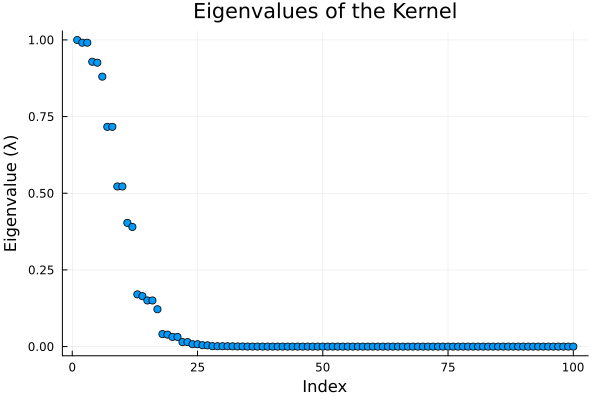

In [22]:
# --------------------------------------------------------
# 1) Define the kernel D(ξ, ξ'), for a given N^{2D}.
#    D(ξ, ξ') = [ sqrt(N^{2D}) * J1( sqrt(N^{2D}) * r ) ] / [ 2π * r ]
#    where r = ||ξ - ξ'|| in R^2.
#
#    For r -> 0, web use the limit:
#        J1(z) ~ z/2  => D(ξ, ξ) ~ [ N^{2D} / 2 ] / [2π] = N^{2D} / (4π).
# --------------------------------------------------------
function D_kernel(xi::Tuple{Real,Real}, xip::Tuple{Real,Real}, N2D::Real)
    # Euclidean distance
    dx = xi[1] - xip[1]
    dy = xi[2] - xip[2]
    r = sqrt(dx*dx + dy*dy)

    # handle r ~ 0 using limiting value
    if r == 0
        # limit as r->0:  D(ξ, ξ) = N^{2D}/(4π)
        return N2D/(4π)
    else
        alpha = sqrt(N2D) * r
        return ( sqrt(N2D) * besselj(1, alpha ) ) / ( 2π * r )
    end
end

# --------------------------------------------------------
# 2) Build a discrete set of points in R_* (circle radius 2),
#    and form the matrix that approximates the integral operator.
# --------------------------------------------------------
"""
    build_operator_matrix(N2D, eN)

Discretize R_* = {(x,y): x^2 + y^2 <= 4} with a uniform grid of size eN x eN
covering [-2,2] x [-2,2]. Keep only points inside the circle of radius 2.

We build a matrix M of size n x n, where n = #points in the circle:
    M[i,j] ~ D(ξᵢ, ξⱼ) * dA
where dA is the area element. This approximates the integral operator
  (Kψ)(ξᵢ) = ∑ⱼ M[i,j] ψⱼ,
which corresponds to
  ∫ D(ξ, ξ') ψ(ξ') dξ' over R_*.

Returns:
 - M, the n x n matrix
 - coords, a Vector of the points (ξᵢ)
 - dA, the area of each cell
"""
function build_operator_matrix(N2D::Real, eN::Int)

    # 1) Build a uniform grid in [-2, 2] x [-2, 2].
    xvals = range(-2.0, 2.0, length=eN)
    yvals = range(-2.0, 2.0, length=eN)

    Δ = 4.0 / (eN - 1)   # spacing in each dimension
    dA = Δ * Δ           # area element in the Riemann sum

    # 2) Collect points inside the circle r <= 2
    points = Tuple{Float64,Float64}[]
    for y in yvals
        for x in xvals
            if x^2 + y^2 <= 4.0
                push!(points, (x,y))
            end
        end
    end

    n = length(points)
    println("Number of points inside the circle of radius 2 = $n.")

    # 3) Construct the kernel matrix
    #    M[i,j] = D_kernel(xi, xj, N2D) * dA
    M = Matrix{Float64}(undef, n, n)

    for i in 1:n
        xi = points[i]
        for j in 1:n
            xj = points[j]
            M[i,j] = D_kernel(xi, xj, N2D) * dA
        end
    end

    return M, points, dA
end


# --------------------------------------------------------
# 60a) Solve the eigenvalue problem:
#      ∫ D(ξ, ξ') ψ(ξ') dξ' = λ ψ(ξ).
#
#    In discrete form:
#      M ψ = λ ψ,
#    where M is the matrix from build_operator_matrix.
# --------------------------------------------------------
"""
    solve_eigenproblem(N2D, eN; nev=10)

1) Build the operator matrix M for the chosen N2D (the 'bandlimit' parameter).
2) Compute the eigenvalues/eigenvectors of M.
3) Return the (nev) largest eigenvalues (by magnitude).

Note: In practice, you might want to use sparse methods or bigger eN for better accuracy.
"""
function solve_eigenproblem(N2D::Real, eN::Int; nev=10)
    # Build the operator matrix
    M, coords, dA = build_operator_matrix(N2D, eN)

    # Solve for eigenvalues/eigenvectors. M is typically dense here.
    # eigen(M) returns all eigenvalues (and vectors).
    # The operator might be symmetric/positive, so we can do eigen(Symmetric(M)) if it’s real-symmetric.
    decomp = LinearAlgebra.eigen(LinearAlgebra.Symmetric(M))

    # The eigenvalues are in ascending order typically, so let's sort by magnitude descending if needed.
    # By default, 'eigen' with Symmetric will return ascending (lowest -> highest).
    # We can reverse them:
    vals = reverse(decomp.values)
    vecs = reverse(eachcol(decomp.vectors))

    # Return just the top nev
    nval = min(nev, length(vals))
    return vals[1:nval], vecs[1:nval], coords, M
end

N2D = 10.0        
eN  = 50          
nev = 100         

λs, ψs, coords, M = solve_eigenproblem(N2D, eN; nev=nev)

println("Largest $nev eigenvalues (by magnitude) from the discrete operator:")
λs = solve_eigenproblem(N2D, eN; nev=nev)

# Plot the eigenvalues
plot(1:nev, λs, seriestype=:scatter, marker=:circle, label="", title="Eigenvalues of the Kernel",xlabel="Index", ylabel="Eigenvalue (λ)", grid=true)


In [45]:
using LinearAlgebra
using SpecialFunctions
using Plots

# -----------------------------
# 1. Define the kernel function.
#
# The kernel in scaled (ξ) variables is given by
#   D(ξ,ξ') = (√(N2D) * J₁(√(N2D)*r))/(2π r),    r = ||ξ - ξ'||
# with the limiting value at r=0:
#   lim₍r→0₎ D(ξ,ξ') = (N2D)/(4π)
# -----------------------------
function kernel_D(ξ::Tuple{Float64,Float64}, η::Tuple{Float64,Float64}, N2D::Float64)
    # Euclidean distance between ξ and η
    r = sqrt((ξ[1]-η[1])^2 + (ξ[2]-η[2])^2)
    if r == 0.0
        return N2D/(4π)  # use the limit: J₁(z) ~ z/2 as z->0
    else
        return (sqrt(N2D)*besselj(1, sqrt(N2D)*r))/(2π*r)
    end
end

# -----------------------------
# 2. Discretize the integration region R*
#
# We take R* to be a disk of radius 2 (so its area is π*2^2 = 4π).
# We generate a uniform Cartesian grid over [-2,2]×[-2,2] and keep
# only the points that lie inside the disk.
# -----------------------------
function generate_disk_points(eN_grid::Int)
    # Define a uniform grid over [-2,2] in each coordinate.
    xs = range(-2.0, 2.0, length=eN_grid)
    ys = range(-2.0, 2.0, length=eN_grid)
    Δ = (4.0)/(eN_grid - 1)   # grid spacing in x and y (the cell area will be Δ²)
    points = Tuple{Float64,Float64}[]
    for y in ys, x in xs
        if x^2 + y^2 <= 4.0   # inside disk of radius 2
            push!(points, (x, y))
        end
    end
    return points, Δ^2  # return list of points and the (approximate) quadrature weight for each
end

# -----------------------------
# 3. Build the discretized integral operator.
#
# The discretized eigenvalue problem is
#
#    ∑₍j₎ D(ξᵢ,ξⱼ) ψ(ξⱼ) wⱼ  ≈  λ ψ(ξᵢ),
#
# where wⱼ is the quadrature weight at the jth point.
#
# To obtain a symmetric matrix we form
#
#    L_sym(i,j) = √(wᵢ) * D(ξᵢ,ξⱼ) * √(wⱼ).
#
# -----------------------------
function build_operator(points::Vector{Tuple{Float64,Float64}}, weight::Float64, N2D::Float64)
    npts = length(points)
    # Preallocate the (unweighted) kernel matrix D_mat.
    D_mat = zeros(Float64, npts, npts)
    for i in 1:npts
        for j in 1:npts
            D_mat[i,j] = kernel_D(points[i], points[j], N2D)
        end
    end
    # Create the diagonal weight factor (all points get the same weight here).
    wvec = fill(weight, npts)
    W = Diagonal(sqrt.(wvec))
    # Form the symmetric discretized operator.
    L_sym = W * D_mat * W
    return L_sym, wvec
end

# -----------------------------
# 4. Solve the eigenvalue problem.
#
# For the symmetric matrix L_sym we solve
#
#    L_sym v = λ v.
#
# The discretized eigenfunction at the grid points is recovered by:
#
#    ψ = v ./ sqrt(wvec).
#
# -----------------------------
function solve_eigenproblem(L_sym::Matrix{Float64}, wvec::Vector{Float64})
    eig_res = eigen(L_sym)
    # Sort eigenvalues (and eigenvectors) in descending order.

    ind = sortperm(eig_res.values, rev=true)
    λ_sorted = eig_res.values[ind]
    V_sorted = eig_res.vectors[:, ind]
    # Recover eigenfunctions (in the unweighted space) at the discretization points.
    ψs = [V_sorted[:,k] ./ sqrt.(wvec) for k in 1:length(λ_sorted)]
    return λ_sorted, ψs
end

# -----------------------------
# 5. Plot eigenvalues and selected eigenfunctions.
# -----------------------------


# Set the parameter for the planar Shannon number (N^{2D}).
# (You may adjust this value as needed.)
N2D = 20.0

# Set grid resolution for the discretization of the disk R* (area = 4π).
eN_grid = 51  # number of grid points along one dimension (in the bounding square)

# Generate points in the disk and the quadrature weight (Δ²).
points, weight = generate_disk_points(eN_grid)
println("Number of discretization points in R* = ", length(points))

# Build the discretized (symmetric) operator.
L_sym, wvec = build_operator(points, weight, N2D)

# Solve the eigenvalue problem.
λ_sorted, ψs = solve_eigenproblem(L_sym, wvec)

println("First 10 eigenvalues:")
for (i, λ) in enumerate(λ_sorted[1:10])
    println("λ[$i] = ", λ)
end



Number of discretization points in R* = 1961
First 10 eigenvalues:
λ[1] = 0.9999964541924463
λ[2] = 0.999889883927019
λ[3] = 0.9998898839270178
λ[4] = 0.9984934232704146
λ[5] = 0.9983633414587206
λ[6] = 0.9971113081747469
λ[7] = 0.986706362783295
λ[8] = 0.9867063627832922
λ[9] = 0.9677892322236199
λ[10] = 0.9677892322236189


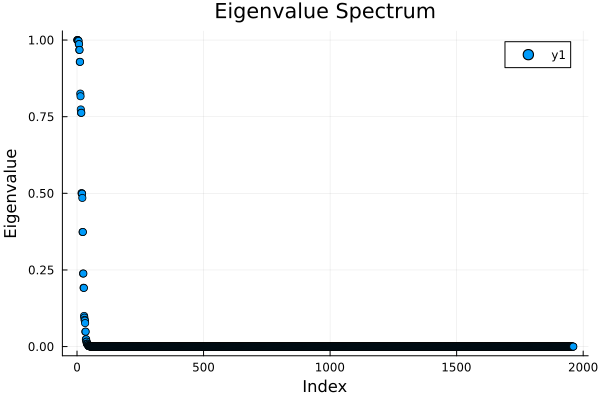

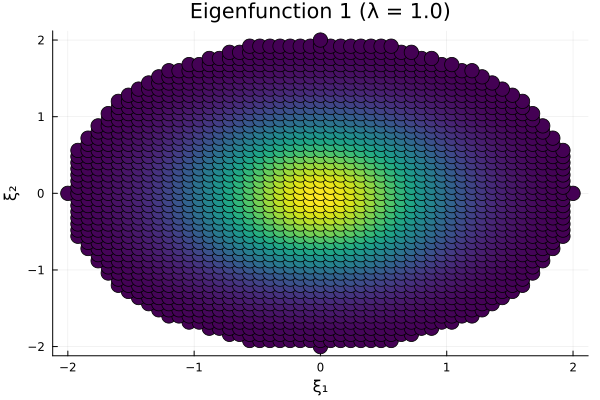

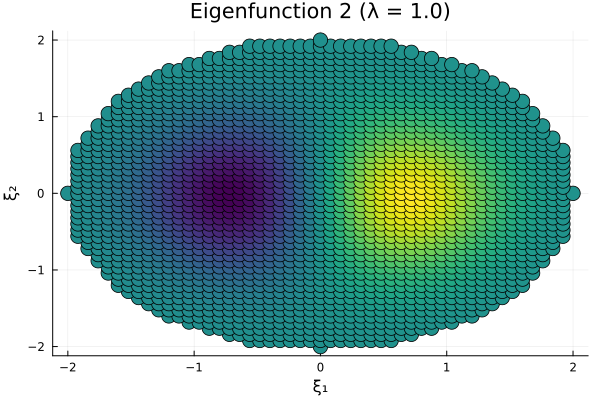

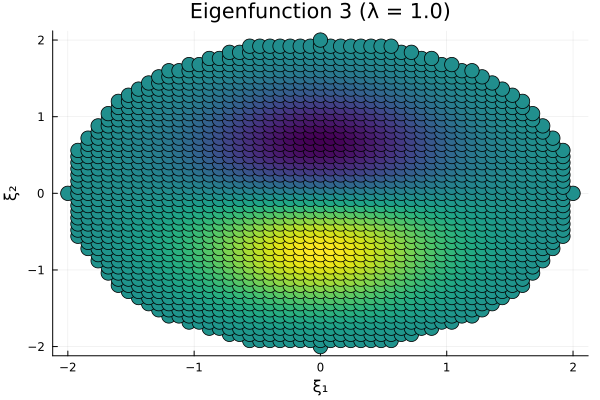

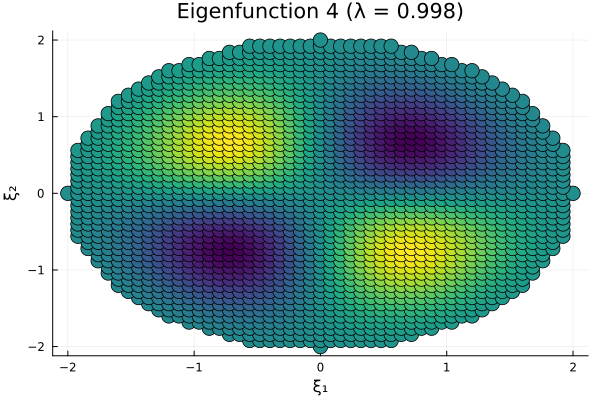

In [46]:
function plot_results(λ_sorted::Vector{Float64}, ψs::Vector{Vector{Float64}},
                      points::Vector{Tuple{Float64,Float64}}, num_eigenfuncs::Int)
    # Plot the eigenvalue spectrum.
    plt_eigs = plot(λ_sorted, seriestype=:scatter, title="Eigenvalue Spectrum",
                    xlabel="Index", ylabel="Eigenvalue", markersize=4)
    display(plt_eigs)

    # Now make scatter plots for the first few eigenfunctions.
    # We will plot the spatial pattern on the disk.
    for k in 1:num_eigenfuncs
        ψ = ψs[k]
        # Extract x and y coordinates.
        xs = [p[1] for p in points]
        ys = [p[2] for p in points]
        plt_ψ = scatter(xs, ys, marker_z=ψ, color=:viridis, ms=8,
                        xlabel="ξ₁", ylabel="ξ₂",
                        title="Eigenfunction $(k) (λ = $(round(λ_sorted[k], digits=3)))",
                        legend=false)
        # Optionally, add a colorbar.
        display(plt_ψ)
    end
end
# Plot the eigenvalue spectrum and the first few eigenfunctions.
num_eigenfuncs_to_plot = 4
plot_results(λ_sorted, ψs, points, num_eigenfuncs_to_plot)


## 5.3: Circular Spacelimitation

In [77]:
using LinearAlgebra
using SpecialFunctions   # for besselj
using QuadGK            # for numerical integration
using Plots

# ------------------------------------------------------------------------------
# 1) Define the kernel for fixed m:
#    D(r, r') = K^2 ∫[0..1]  J_m(K p r)  J_m(K p r')  p dp
#
# We'll implement a function to numerically evaluate D(r, r') by quadgk.
# We also handle the limiting case (r=0 or r'=0) in the integral automatically.
# ------------------------------------------------------------------------------
function radial_kernel(m::Integer, r::Float64, rp::Float64, K::Float64)
    # If either r=0 or rp=0, we rely on the integral plus bessel function behavior.
    # We can simply compute the integral numerically for general r, r'.
    integrand(p) = besselj(m, K*p*r)*besselj(m, K*p*rp)*p
    # Evaluate integral from p=0..1
    val, _ = quadgk(integrand, 0.0, 1.0)
    return K^2 * val
end

# ------------------------------------------------------------------------------
# 2) Build the discretized operator for the integral equation
#
#     ∫[0..R] D(r, r') g(r') r' dr' = λ g(r).
#
# We'll use a simple uniform grid in r, say r_i in [0, R], i=1..Nr.
# The matrix M approximating the operator is of size Nr×Nr:
#
#     M[i,j] = D(r_i, r_j)* r_j * Δr
#
# because we are approximating the integral by a Riemann sum:
#     ∫ f(r') r' dr' ≈ ∑[j] f(r_j) * r_j * Δr
#
# ------------------------------------------------------------------------------
function build_operator_matrix(m::Integer, K::Float64, R::Float64, Nr::Int)
    # Discretize r in [0, R] with Nr points
    # (You could choose a different distribution, e.g. Chebyshev or Gaussian quadrature.)
    rs = range(0.0, R, length=Nr)
    Δr = R/(Nr-1)  # uniform spacing

    # Allocate operator matrix
    M = zeros(Float64, Nr, Nr)

    for i in 1:Nr
        for j in 1:Nr
            r_i = rs[i]
            r_j = rs[j]
            # kernel
            D_ij = radial_kernel(m, r_i, r_j, K)
            # multiply by measure factor (r_j * Δr) for the integral
            M[i,j] = D_ij * r_j * Δr
        end
    end

    return M, collect(rs)  # return the matrix and the vector of r-values
end

# ------------------------------------------------------------------------------
# 3) Solve the eigenvalue problem:
#     M * g = λ * g
# The largest few eigenvalues/eigenvectors are typically of interest. 
# We'll solve them all here, but for big Nr you might want an iterative solver.
# ------------------------------------------------------------------------------
function solve_eigenproblem(M::Matrix{Float64})
    # M is real symmetric (for each fixed m), so we can use eigen() in Julia.
    # But note: the matrix might be large, so in real applications we might
    # use iterative methods or only partial diagonalization.
    # For demonstration, we do a full solve.
    @time E = eigen(M)
    λs = E.values
    vs = E.vectors
    # Sort eigenvalues (and corresponding vectors) in descending order
    idx = sortperm(λs, by=abs, rev=true)

    # idx = sortperm(real(λs), rev=true)
    λs_sorted = λs[idx]
    vs_sorted = vs[:, idx]

    return λs_sorted, vs_sorted
end

# ------------------------------------------------------------------------------
# 4) Plot results: 
#    - eigenvalue spectrum 
#    - a few radial eigenfunctions g(r)
# ------------------------------------------------------------------------------
function plot_results(m::Integer, rs::Vector{Float64},
                      λs::Vector{Float64}, vs::Matrix{Float64};
                      num_to_plot::Int=5)
    # 4a) Plot eigenvalue spectrum
    plt_eigs = scatter(1:length(λs), λs, xlabel="Eigen index", ylabel="λ",
                       title="Eigenvalue spectrum (m=$m)", legend=false)
    display(plt_eigs)

    # 4b) Plot radial eigenfunctions
    #     Each column of vs is an eigenvector => we associate it with g(r).
    #     We'll plot the first num_to_plot. 
    #     The vectors are determined up to a normalization factor. 
    #     Typically, we can do simple L2 normalization or something similar.
    for k in 1:min(num_to_plot, size(vs,2))
        gk = vs[:,k]
        λk = λs[k]
        # We can normalize gk so that sum(gk^2 * r * Δr) = 1, for instance. 
        # But for demonstration, we'll just plot the raw vector.
        plt_g = plot(rs, gk, xlabel="r", ylabel="g(r)", 
                     title="Eigenfunction k=$k, λ=$(round(λk,digits=4)) (m=$m)")
        display(plt_g)
    end
end

# ------------------------------------------------------------------------------
# 5) Main driver:
#    - choose m, K, R
#    - build the operator
#    - solve the eigenvalue problem
#    - plot results
# ------------------------------------------------------------------------------


R = 1.0               # radius of the region
N2D = 15.0            # example planar Shannon number => K^2 = N2D => K = sqrt(N2D)
m = 0                 # angular order (try different m: 0, 1, 2, -1, -2, etc.)
Nr = 200              # number of radial points for discretization

K = sqrt(N2D)

println("Building operator matrix for m=$m, K=$K, R=$R, Nr=$Nr ...")
M, rs = build_operator_matrix(m, K, R, Nr)

println("Solving the eigenvalue problem (size $(size(M,1))×$(size(M,2))) ...")
λs, vs = solve_eigenproblem(M)

plt_eigs = scatter(1:length(λs), real(λs), xlabel="Eigen index", ylabel="λ", title="Eigenvalue spectrum (m=$m)", legend=false)
# Print first 5 eigenvalues
println("First 5 eigenvalues (descending):")
for i in 1:50
    println("   λ[$i] = ", real(λs[i]))
end

# Plot the eigenvalues and a few eigenfunctions
# plot_results(m, rs, real(λs), real(vs), num_to_plot=50)


Building operator matrix for m=0, K=3.872983346207417, R=1.0, Nr=200 ...
Solving the eigenvalue problem (size 200×200) ...
  0.015050 seconds (41 allocations: 1.435 MiB)
First 5 eigenvalues (descending):
   λ[1] = 0.9697547857906449
   λ[2] = 0.23560034981746697
   λ[3] = 0.001403513459664498
   λ[4] = 1.0493281664749392e-6
   λ[5] = 2.3616389057599977e-10
   λ[6] = 2.1415708465240758e-14
   λ[7] = 6.95835663034859e-17
   λ[8] = 6.95835663034859e-17
   λ[9] = -8.274756513252807e-17
   λ[10] = -8.274756513252807e-17
   λ[11] = 9.196980638790842e-18
   λ[12] = 9.196980638790842e-18
   λ[13] = 6.636581378009965e-17
   λ[14] = 6.636581378009965e-17
   λ[15] = 1.3908979499527573e-17
   λ[16] = 1.3908979499527573e-17
   λ[17] = -4.352203633492962e-17
   λ[18] = -4.352203633492962e-17
   λ[19] = 3.646400917686534e-17
   λ[20] = 3.646400917686534e-17
   λ[21] = 4.8423391817033156e-17
   λ[22] = -3.7655055977635025e-17
   λ[23] = -3.7655055977635025e-17
   λ[24] = -1.419748388499353e-17
   λ[25

In [80]:
using QuadGK            # for numerical integration quadgk
using SpecialFunctions  # for besselj
using LinearAlgebra
using Plots

# ------------------------------------------------------
# 1) Kernel function for fixed order m
#
#    D_m(r, r') = K^2 * ∫[p=0..1] p dp * J_m(K p r)*J_m(K p r')
# ------------------------------------------------------
function D_m(r::Float64, rp::Float64, m::Integer, N2D::Float64)
    # We define K = sqrt(N2D).
    K = sqrt(N2D)
    integrand(p) = besselj(m, K*p*r) * besselj(m, K*p*rp) * p
    val, err = quadgk(integrand, 0.0, 1.0)
    return N2D * val  # multiply by K^2 = N2D
end

# ------------------------------------------------------
# 2) Build the discretized kernel matrix for a given m
#
# We create a uniform grid r_i in [0,R], i=1..nr, with spacing dr.
# The matrix element for the integral operator is
#
#     A[i,j] = D_m(r_i, r_j) * r_j * dr,
#
# so that
#     (A*g)[i] ≈ ∫ D_m(r_i,r') g(r') r' dr'.
# ------------------------------------------------------
function build_kernel_matrix(m::Integer, N2D::Float64, R::Float64, nr::Int)
    dr = R/(nr-1)
    rs = [i*dr for i in 0:(nr-1)]  # radial grid from 0 to R
    Kmat = zeros(Float64, nr, nr)
    
    # Fill the kernel matrix
    for i in 1:nr
        for j in 1:nr
            Kmat[i,j] = D_m(rs[i], rs[j], m, N2D)
        end
    end
    # Multiply each column j by (r_j * dr)
    # => integral weighting: r' dr'
    for j in 1:nr
        Kmat[:,j] .*= (rs[j] * dr)
    end
    
    return rs, Kmat
end

# ------------------------------------------------------
# 3) Solve the eigenvalue problem for a given m
#
#     ∑_j A[i,j]*g_j = λ * g_i
# 
# We'll return the radial grid rs, all eigenvalues, and
# the corresponding eigenvectors.
# ------------------------------------------------------
function solve_eigenproblem(m::Integer, N2D::Float64, R::Float64, nr::Int)
    rs, Kmat = build_kernel_matrix(m, N2D, R, nr)
    E = eigen(Kmat)  # diagonalize
    # Sort eigenvalues in descending order
    idx = sortperm(real(E.values), rev=true)
    evals = E.values[idx]
    evecs = E.vectors[:, idx]
    return rs, evals, evecs
end

# ------------------------------------------------------
# 4) Main routine:
#    - set parameters
#    - loop over m in [-nev..nev]
#    - store largest eigenvalue & its eigenfunction g_m(r)
#    - plot eigenvalues
#    - plot radial eigenfunctions (largest λ) for each m
# ------------------------------------------------------
function main()
    # Parameters
    N2D  = 20.0        # N^{2D} = K^2
    R    = 1.0         # radius of the circular region
    nr   = 100         # number of radial grid points
    nev  = 3           # we will consider m from -3..3
    
    # We'll keep track of:
    #  - The largest few eigenvalues for each m
    #  - The principal (largest) eigenfunction for each m
    all_evals  = Dict{Int,Vector{Float64}}()
    principal_g = Dict{Int,Vector{Float64}}()
    
    # We'll store a single radial grid (same for all m).
    # The matrix-building uses the same "nr" points. 
    # We'll assume each solve returns the same "rs".
    rs_sample = range(0, R, length=nr)
    
    for m in -nev:nev
        rs, evals, evecs = solve_eigenproblem(m, N2D, R, nr)
        all_evals[m] = evals
        
        # The "principal" eigenfunction is the one with the largest eigenvalue => index 1
        # We might choose the first vector evecs[:,1]. 
        # Optionally, we can normalize the sign so that g(0)≥0, etc.
        g_m = evecs[:,1]
        # We'll store it
        principal_g[m] = g_m
        # Also store the radial coordinates in case we want to check
        rs_sample = rs
    end
    
    # -----------------------------
    # Plot all eigenvalues for each m
    # We'll produce a single "stem"/scatter plot that shows, for each m,
    # the first few eigenvalues. 
    # -----------------------------
    plt_evals = plot(title="Eigenvalues vs. m", xlabel="m", ylabel="Eigenvalue", legend=false)
    # For each m, we plot the largest few eigenvalues
    for m in -nev:nev
        λvals = all_evals[m][1:5]  # say we take the first 5
        # We plot them at x=m+some offset
        scatter!(fill(m, length(λvals)), λvals, marker=:circle, markersize=5)
    end
    display(plt_evals)
    
    # -----------------------------
    # Plot the principal radial eigenfunctions g_m(r) for m in [-nev..nev]
    #
    # We put them all on one graph, each labeled by its m.
    # Because these are discrete vectors, we do a line or scatter plot over r.
    # -----------------------------
    plt_g = plot(title="Principal radial eigenfunctions g_m(r)",
                 xlabel="r", ylabel="g_m(r)", legend=:bottomright)
    
    for m in -nev:nev
        g_m = principal_g[m]
        # Possibly we want to normalize g_m so that max|g_m|=1 for clarity
        # (or integrate g_m^2 r dr = 1, etc).  For demonstration, we just scale
        # so that the maximum is ±1:
        norm_factor = maximum(abs.(g_m))
        g_scaled = g_m ./ norm_factor
        plot!(plt_g, rs_sample, g_scaled, label="m=$m")
    end
    
    display(plt_g)
end

# Execute main
main()


LoadError: InexactError: Float64(5.468226651246553e-18 - 7.518812249529871e-19im)

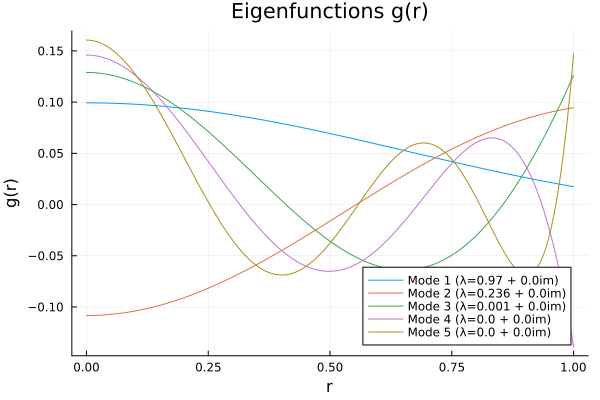

In [57]:
using Plots

p = plot(
    title = "Eigenfunctions g(r)",
    xlabel = "r",
    ylabel = "g(r)"
)

for i in 1:5
    plot!(
        p,
        real(rs),                   # x-values
        real(vs[:, i]),            # y-values for ith eigenfunction
        label = "Mode $i (λ=$(round(λs[i], digits=3)))"
    )
end

display(p)


In [17]:
"""
    D_kernel(r, rp, K, m; rtol=1e-9, atol=1e-12)

Compute the radial kernel

    D(r, r') = K^2 * ∫[0..1] p * J_m(K p r) * J_m(K p r') dp

with numerical integration via quadgk. The result should be symmetric
in (r, r'), but small floating-point discrepancies might arise.

Keyword arguments:
 - rtol: relative tolerance for quadgk
 - atol: absolute tolerance
"""
function D_kernel(r::Real, rp::Real, K::Real, m::Integer; rtol=1e-9, atol=1e-12)
    # If r == rp, we can either integrate directly or do the same approach
    integrand(p) = p * besselj(m, K*p*r) * besselj(m, K*p*rp)
    val, err = quadgk(integrand, 0, 1; rtol=rtol, atol=atol)
    return K^2 * val
end

"""
    build_D_matrix(R, eN, K, m) -> (Dmat, rs)

Discretize r ∈ [0, R] with eN points. Build a symmetric matrix Dmat (size eN×eN),
where Dmat[i, j] = D_kernel(rᵢ, rⱼ, K, m).

To enforce symmetry, compute only the upper triangle and copy it to the lower.
Returns the matrix Dmat and the array of radial points rs.
"""
function build_D_matrix(R::Real, eN::Int, K::Real, m::Integer)
    # Discretize r in [0, R]
    rs = range(0, R, length=eN)
    
    # Initialize the matrix
    Dmat = Matrix{Float64}(undef, eN, eN)
    
    # Fill only the upper triangle (including diagonal)
    for i in 1:eN
        for j in i:eN
            val = D_kernel(rs[i], rs[j], K, m)
            Dmat[i, j] = val
            Dmat[j, i] = val  # Enforce symmetry
        end
    end
    return Dmat, collect(rs)
end

R = 1      # circle radius
eN = 50# number of radial points
K = 2.0      # wavenumber
m = 0        # Bessel function order

Dmat, rs = build_D_matrix(R, eN, K, m)


([2.0 1.9995835357822207 … 1.1821696905151216 1.1534496155137468; 1.9995835357822207 1.9991671871907313 … 1.1819756050565715 1.153263128755254; … ; 1.1821696905151216 1.1819756050565715 … 0.7930251245419135 0.7789983218686014; 1.1534496155137468 1.153263128755254 … 0.7789983218686014 0.7654771697333442], [0.0, 0.02040816326530612, 0.04081632653061224, 0.061224489795918366, 0.08163265306122448, 0.10204081632653061, 0.12244897959183673, 0.14285714285714285, 0.16326530612244897, 0.1836734693877551  …  0.8163265306122449, 0.8367346938775511, 0.8571428571428571, 0.8775510204081632, 0.8979591836734694, 0.9183673469387755, 0.9387755102040817, 0.9591836734693877, 0.9795918367346939, 1.0])

### Sanity check for D

symmetric D?
True


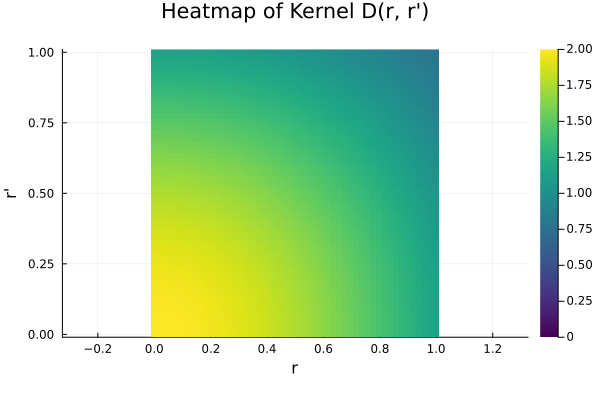

In [18]:
maxdiff = maximum(abs.(Dmat .- Dmat'))
println("symmetric D?")
printb(isapprox(maxdiff, 0))

heatmap(rs, rs, Dmat,
    xlabel="r",
    ylabel="r'",
    title="Heatmap of Kernel D(r, r')",
    color=:viridis,
    aspect_ratio=:equal,
    clims=(0, maximum(Dmat)))  # set color limits to make it visually clearer


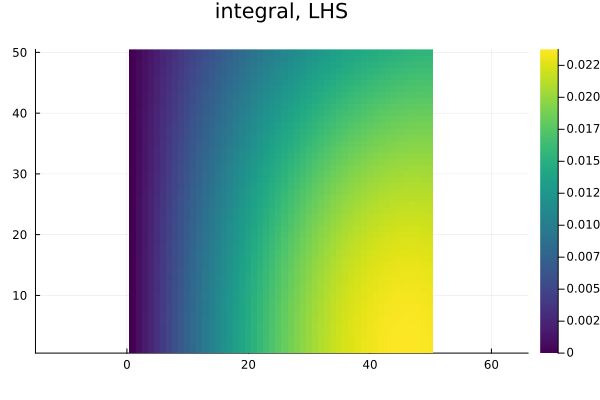

In [19]:
function build_LHS_operator(R::Real, eN::Int, K::Real, m::Integer)
    # radial spacing for uniform grid
    Δr = R/(eN-1)

    # operator matrix: M_{i,j} = D(r_i, r_j) * [r_j * Δr]
    M = Matrix{Float64}(undef, eN, eN)
    for i in 1:eN
        for j in 1:eN
            M[i,j] = Dmat[i,j] * (rs[j] * Δr)
        end
    end

    return M, rs
end

A, rs = build_LHS_operator(R, eN, K, m)
heatmap(A,
    title="integral, LHS",
    color=:viridis,
    aspect_ratio=:equal,
    clims=(0, maximum(A))) 


  0.495434 seconds (636.63 k allocations: 71.155 MiB, 57.29% compilation time)


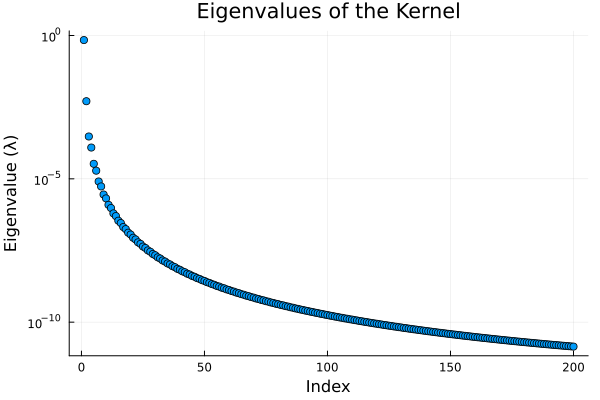

In [20]:
##############################################################################
# 1) Build the matrix M using Gauss–Legendre nodes & weights in [0,1].
##############################################################################

"""
    build_operator_matrix_gauss(N2D, m, N)

Constructs the NxN matrix M for the operator:
    (Tψ)(ξ_i) = 2√(N^2D) ∑_{j=1..N} J_m(2√(N^2D) * ξ_i * ξ_j) * ψ(ξ_j) * (ξ_j w_j).

where {ξ_j, w_j} are Gauss–Legendre nodes, weights on [0,1].
m is the Bessel function order.

Returns:
 - M   : NxN operator matrix
 - xis : array of the Gauss–Legendre nodes ξ_j
 - ws  : array of the Gauss–Legendre weights w_j
"""
function build_operator_matrix_gauss(N2D::Float64, m::Integer, N::Int)
    # 1) Gauss–Legendre nodes & weights on [0,1]
    #    FastGaussQuadrature.gausslegendre(N, 0, 1)
    #    returns nodes in (0,1) and corresponding weights.
    xis, ws = gausslegendre(N)

    alpha = 2*sqrt(N2D)  # factor

    # 2) Construct matrix M: M[i,j] = alpha * besselj(m, alpha * ξ_i * ξ_j) * (ξ_j * w_j)
    M = Matrix{Float64}(undef, N, N)
    for i in 1:N
        xi = xis[i]
        for j in 1:N
            xj = xis[j]
            M[i,j] = alpha * besselj(m, alpha*xi*xj) * (xj * ws[j])
        end
    end

    return M, xis, ws
end

##############################################################################
# 2) Solve the eigenvalue problem: M*g = μ*g => λ = μ^2
##############################################################################

"""
    solve_eigenproblem_gauss(N2D, m, N; nev=5)

Build and solve the integral-operator matrix using Gauss–Legendre quadrature.
M*g = μ*g => μ = sqrt(λ).

Returns:
  mus[1:nev], lambdas[1:nev], evecs[:,1:nev], xis, ws
"""
function solve_eigenproblem_gauss(N2D::Float64, m::Integer, N::Int; nev=5)
    M, xis, ws = build_operator_matrix_gauss(N2D, m, N)

    # M should be real symmetric => use eigen(Symmetric(M))
    decomp = eigen(Symmetric(M))

    # eigen() typically gives ascending order => reverse to get largest first
    vals_all = decomp.values
    vecs_all = decomp.vectors
    idx = sortperm(vals_all, rev=true)
    mus_all = vals_all[idx]               # μ_i
    evecs_all = vecs_all[:,idx]

    # Then λ_i = μ_i^2
    lambdas_all = [μ^2 for μ in mus_all]

    nret = min(nev, length(mus_all))
    return (mus_all[1:nret],
            lambdas_all[1:nret],
            evecs_all[:,1:nret],
            xis,
            ws)
end


N2D = (K*R)^2 / (4*pi)    # e.g. (K*R)^2 / 4 if K*R=2 => N2D=1
m   = 0      # Bessel order
N   = 1000     # number of Gauss–Legendre nodes
nev = 200      # number of eigenvalues to compute

@time mus, lambdas, evecs, xis, ws = solve_eigenproblem_gauss(N2D, m, N; nev=nev)

plot(1:nev, lambdas; yscale = :log10,seriestype = :scatter, marker = :circle,label = "",title = "Eigenvalues of the Kernel",xlabel = "Index",ylabel = "Eigenvalue (λ)",grid = true)
# evecs[:,i] gives the discrete eigenfunction for μ[i].
#   => M*g_i = μ[i]*g_i => T*g_i = μ[i]*g_i
# Then λ[i] = μ[i]^2.


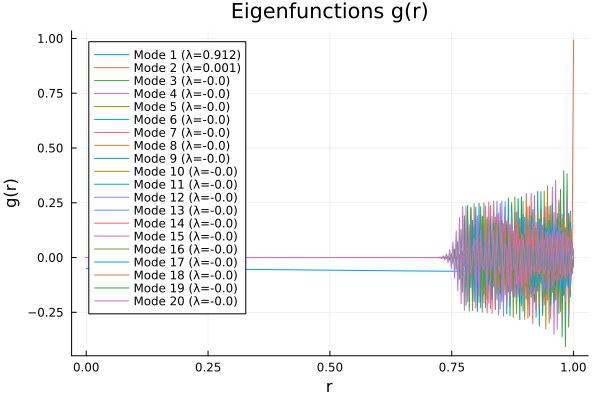

In [21]:
# ------------------------------------------------
# 1) The kernel D(r, r') for integer order m
# ------------------------------------------------
"""
    D_kernel(r, rp, K, m)

Compute 
    D(r, r') = K^2 * ∫[0..1] p * J_m(K p r) * J_m(K p rp) dp.
"""
function D_kernel(r::Real, rp::Real, K::Real, m::Integer)
    integrand(p) = p * besselj(m, K*p*r) * besselj(m, K*p*rp)
    val, err = quadgk(integrand, 0, 1)
    return K^2 * val
end

# ------------------------------------------------
# 2) Build the "operator" matrix for the integral
#    eqn: ∫[0..R] D(r, r') g(r') r' dr' = λ g(r)
# ------------------------------------------------
"""
    build_operator_matrix(R, eN, K, m) 
        -> (M, rs)

- Discretizes r in [0, R] into eN points using a simple trapezoid rule.
- M[i,j] = D(r_i, r_j) * r_j * w_j,
  where w_j is the trapezoidal integration weight at r_j.
- Returns M (an eN x eN matrix) and rs (the radial points).
"""
function build_operator_matrix(R::Real, eN::Int, K::Real, m::Integer)
    # 1) Discretize r in [0, R]
    rs = range(0, R, length=eN)
    dr = R / (eN - 1)

    # 2) Trapezoidal weights
    #    w[1] = w[eN] = dr/2, others = dr
    w = fill(dr, eN)
    w[1] = dr/2
    w[end] = dr/2

    # 3) Build the matrix M
    M = Matrix{Float64}(undef, eN, eN)

    for i in 1:eN
        ri = rs[i]
        for j in 1:eN
            rj = rs[j]
            M[i,j] = D_kernel(ri, rj, K, m) * (rj * w[j])
        end
    end

    return M, collect(rs)
end

# ------------------------------------------------
# 3) Solve the eigenvalue problem:
#    M * g = λ * g
# ------------------------------------------------
"""
    solve_radial_eigenproblem(R, eN, K, m; nev=1)

Builds the matrix and solves for the largest `nev` eigenvalues/eigenvectors.
Returns:
 - λs: the eigenvalues
 - vs: the corresponding eigenvectors (each is a Vector{Float64})
 - rs: the radial grid points
"""
function solve_radial_eigenproblem(R::Real, eN::Int, K::Real, m::Integer; nev=1)
    M, rs = build_operator_matrix(R, eN, K, m)
    # Symmetric kernel => M should be real-symmetric:
    decomp = eigen(Symmetric(M))
    # Eigenvalues come back in ascending order, so let's reverse them:
    vals = reverse(decomp.values)
    vecs = reverse(eachcol(decomp.vectors))
    # Return the top nev
    nval = min(nev, length(vals))
    λs = vals[1:nval]
    vs = vecs[1:nval]
    return λs, vs, rs
end

# ------------------------------------------------
# 4) Example Usage
# ------------------------------------------------
# Parameters
R = 1.0     # circle radius
eN = 300     # number of radial points
K = 2.0     # wavenumber
m = 0       # Bessel order
nev = 20     # number of eigenvalues to extract

# Solve the radial integral equation
λs, vs, rs = solve_radial_eigenproblem(R, eN, K, m; nev=nev)

# Plot the corresponding eigenfunction(s) g(r)
# Typically, the first (largest) eigenvalue/eigenfunction is the fundamental mode.
p = plot(title="Eigenfunctions g(r)", xlabel="r", ylabel="g(r)")
for i in 1:nev
    plot!(rs, vs[i], label="Mode $i (λ=$(round(λs[i],digits=3)))")
end
display(p)


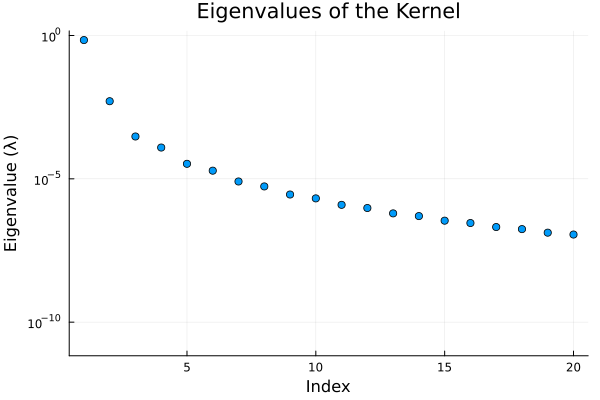

In [19]:
plot(1:nev, lambdas; yscale = :log10,seriestype = :scatter, marker = :circle,label = "",title = "Eigenvalues of the Kernel",xlabel = "Index",ylabel = "Eigenvalue (λ)",grid = true)